C:\Users\david\AppData\Local\Temp\ipykernel_1432\1575400911.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Using cpu device
------------------------------
| time/              |       |
|    fps             | 1613  |
|    iterations      | 1     |
|    time_elapsed    | 10    |
|    total_timesteps | 16384 |
------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 1396      |
|    iterations           | 2         |
|    time_elapsed         | 23        |
|    total_timesteps      | 32768     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -9.93     |
|    explained_variance   | 0         |
|    learning_rate        | 0.00025   |
|    loss                 | 6.94e+20  |
|    n_updates            | 10        |
|    policy_gradient_loss | -1.28e-09 |
|    std                  | 1         |
|    value_loss           | 1.58e+21  |
---------------------------------------
------

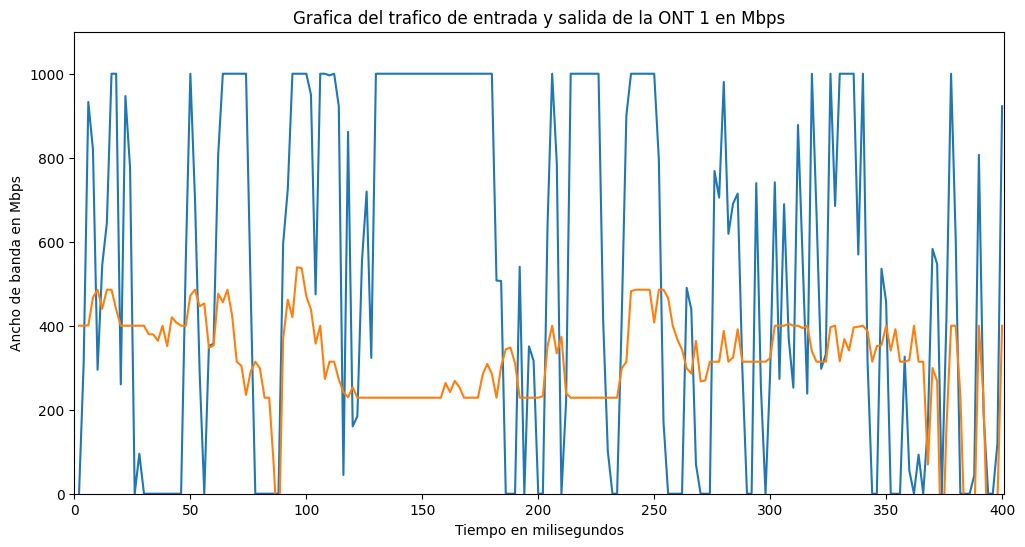

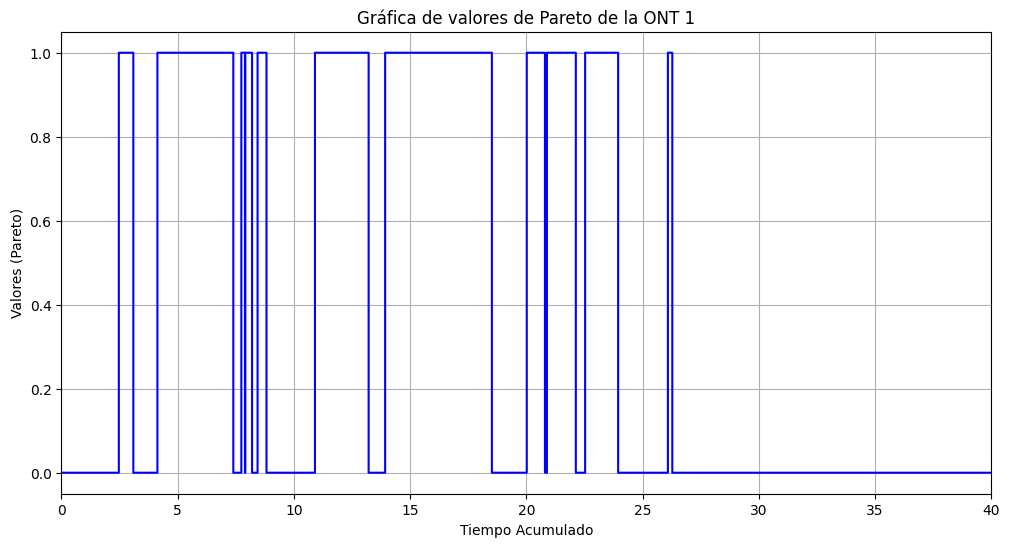

258.32264077154747


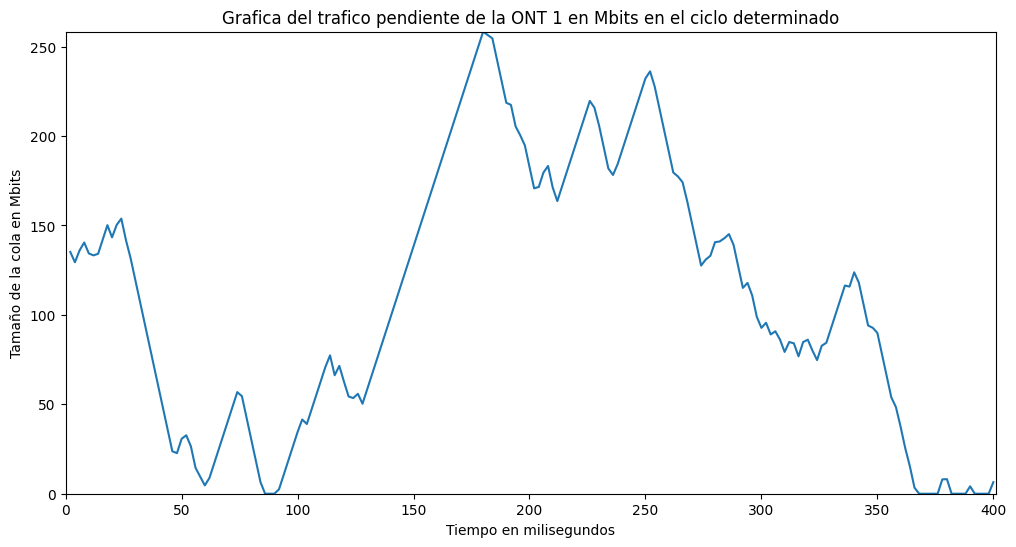

Valores de la ONT 1 de entrada son: [1000.0, 793.9477666553394, 0.0, 129.918399569389, 0.0, 317.31960872722857, 0.0, 0.0, 327.6907223184966, 1000.0, 614.3748584581303, 736.467727557627, 953.9494047365289, 628.5928475917889, 618.0617848041425, 482.9696287131316, 18.15270744644648, 0.0, 0.0, 442.373565817248, 459.17818724960813, 548.3228328562379, 1000.0, 296.7544959030151, 0.0, 0.0, 275.49913864701085, 0.0, 369.143512193138, 376.46594062428875, 66.73290104468965, 208.78005006335212, 0.0, 105.05848683853247, 865.3737613446273, 1000.0, 644.0985865964435, 99.59558423896675, 964.0469526974158, 1000.0, 851.8255996885609, 99.63474418688278, 0.0, 147.25288692635607, 437.9417856303315, 0.0, 458.14894476986916, 0.0, 0.0, 0.0, 975.1401066713701, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 658.4865688263983, 0.0, 0.0, 0.6521073724349291, 317.49378990384747, 0.0, 0.0, 941.2933934449104, 1000.0, 1000.0, 1000.0, 1000.0, 711.9494356347312, 520.7625755659277,

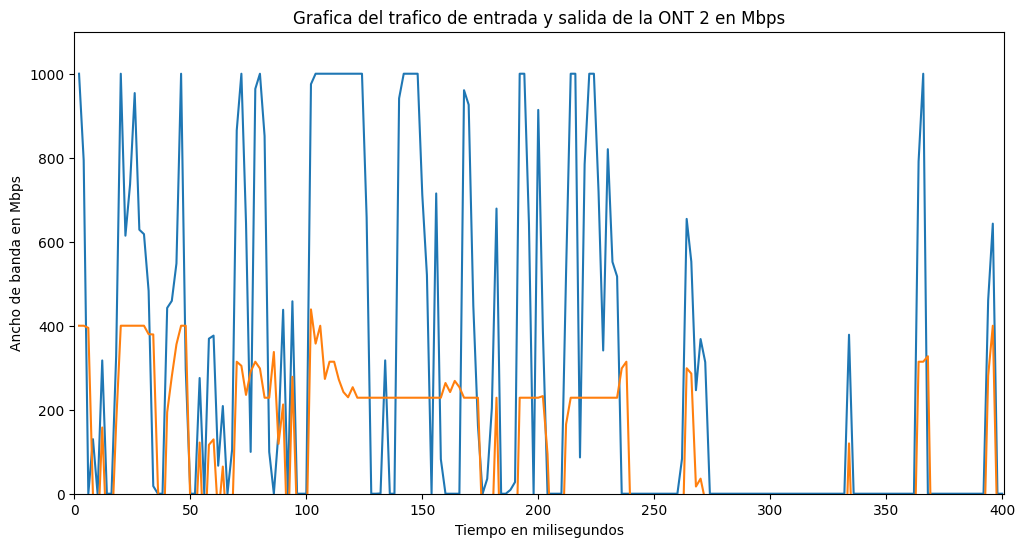

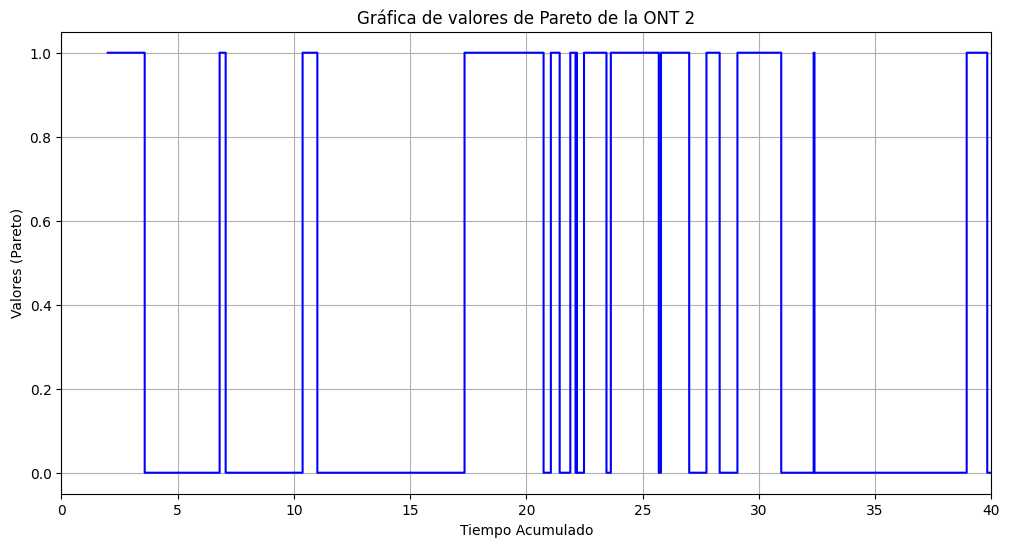

96.67253332370348


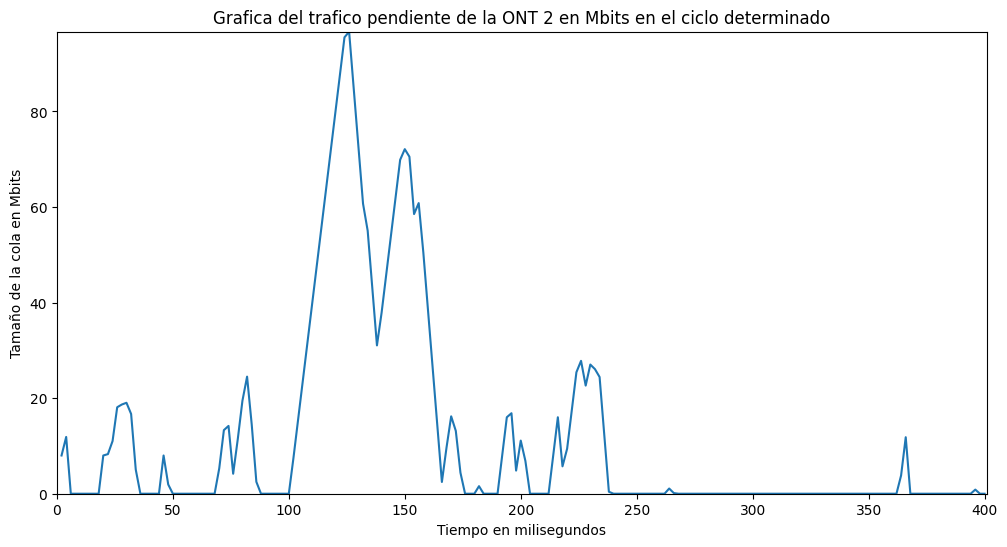

Valores de la ONT 2 de entrada son: [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 881.0568029874423, 566.8813238825339, 810.0353350842106, 601.3723063544645, 560.9307133214942, 0.0, 0.0, 0.0, 527.9587417947696, 1000.0, 607.2087406474371, 0.0, 340.51475122268874, 1000.0, 911.4388848178102, 742.9837138836426, 820.403037925675, 629.0906783915467, 1000.0, 905.6458023893468, 607.696908421242, 32.121470133152144, 0.0, 425.3616780190153, 121.41792580811362, 324.74413464606886, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.29109596617945, 0.0, 111.22409334543792, 4.865344036672048, 297.9674851149827, 0.0, 550.2414843237133, 1000.0, 904.2059928459961, 944.3181828123247, 977.6400046638413, 540.215512844003, 599.3496420596493, 934.1896710097166, 1000.0, 188.72624731547648, 0.0, 72.19416853632454, 923.465697926536, 725.206009691905, 1000.0, 1000.0, 1000.0, 1000.0, 892.3755814239878, 493.99166249303977, 0.0, 0.0, 0.0, 0.0, 629.5996322572845, 

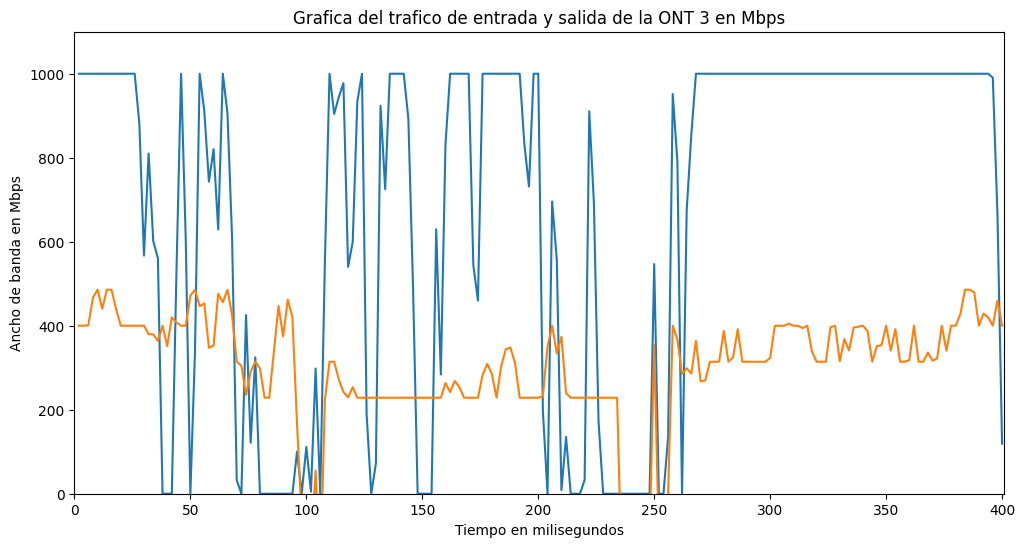

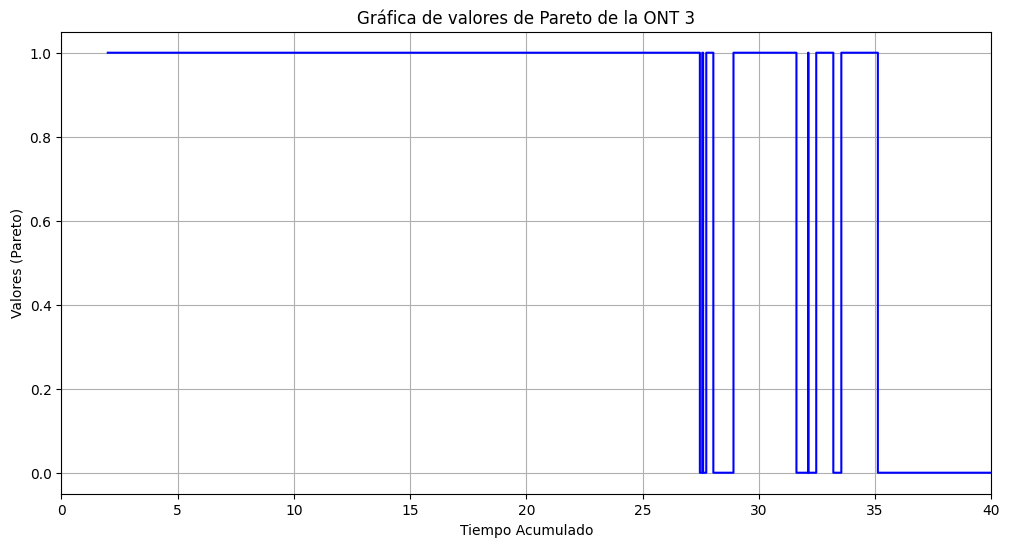

527.6930613787973


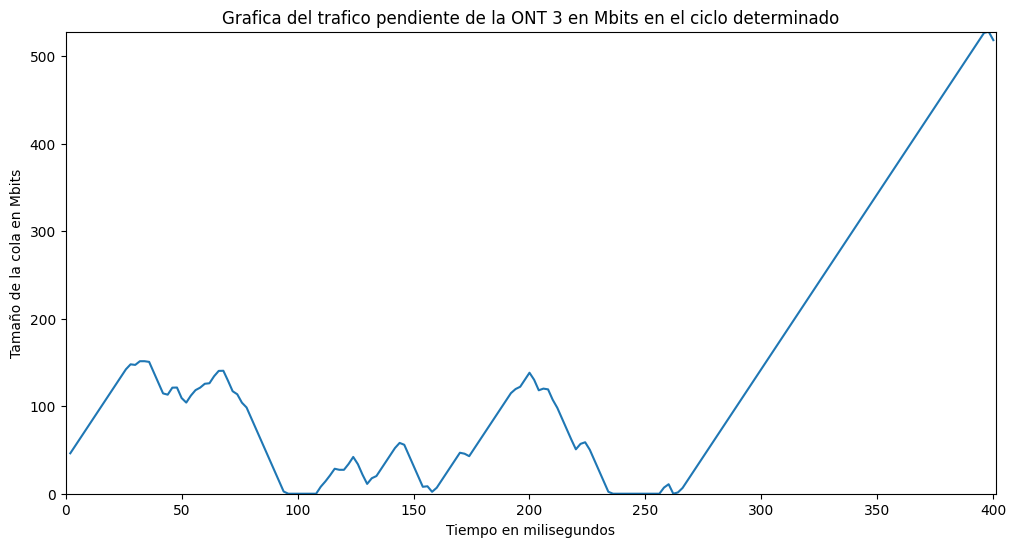

Valores de la ONT 3 de entrada son: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.30258701417345, 951.5375112166632, 963.133494749089, 471.33719788206906, 1000.0, 324.9156327619924, 0.0, 0.0, 0.0, 0.0, 166.2109880649848, 0.0, 0.0, 241.1572586692159, 745.1375324336178, 178.1758723353294, 819.8174972481922, 808.6988088392384, 33.89118207086095, 0.0, 0.0, 296.59438595607855, 505.11619728206637, 592.3816461004417, 424.76187519009403, 686.7150247179823, 776.6404547980385, 865.739020214932, 297.01882151255666, 468.8274209005958, 631.0364169417687, 776.5882975925598, 544.3978448415263, 487.5663990620538, 546.3339179041633, 937.6656531327799, 1000.0, 1000.0, 1000.0, 592.8309038925782, 1000.0, 143.46579594954622, 0.0, 0.0, 0.0, 505.7163525771857, 319.7330104028255, 423.8971343185806, 1000.0, 773.7667968922594, 410.56362373262965, 606.3199164990496, 803.64912742518

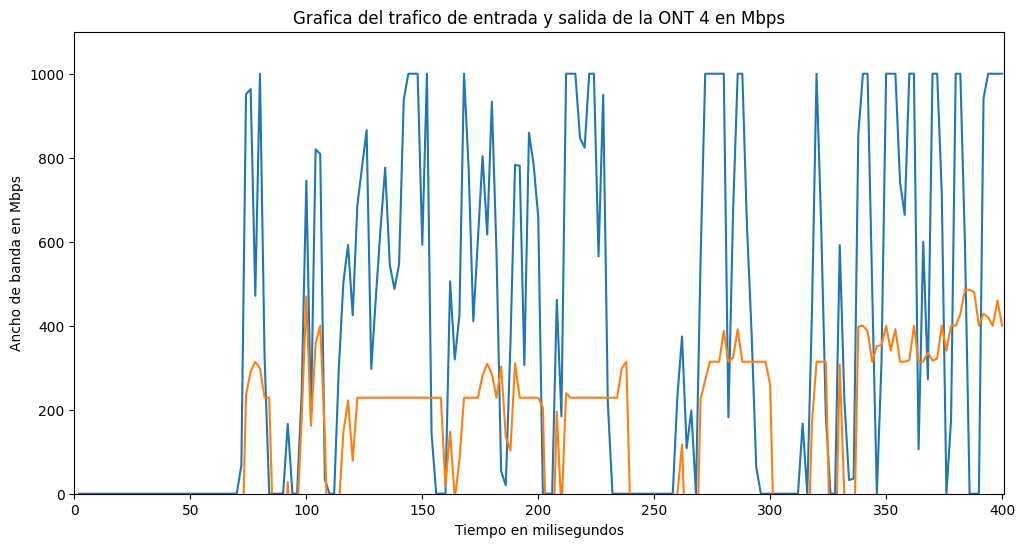

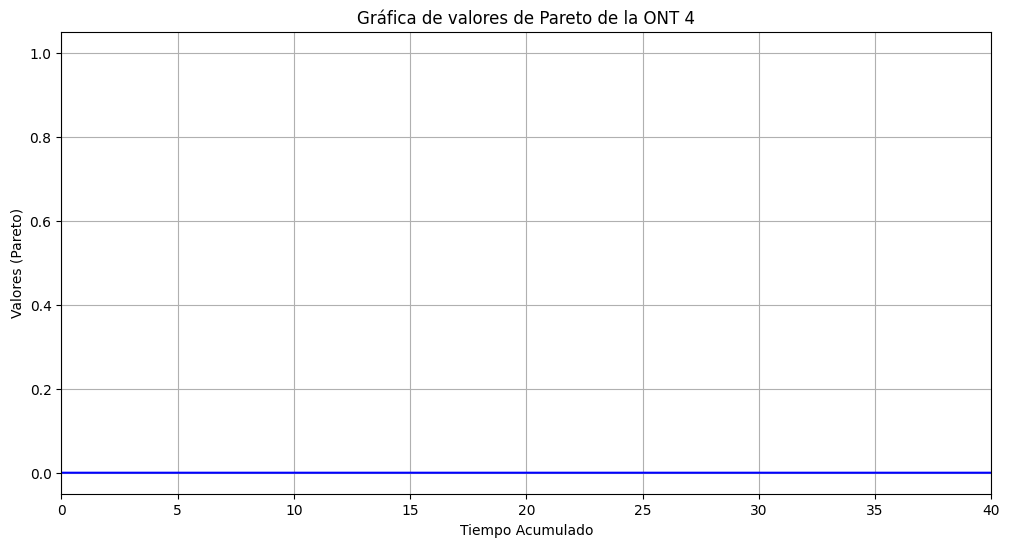

55.712470909367205


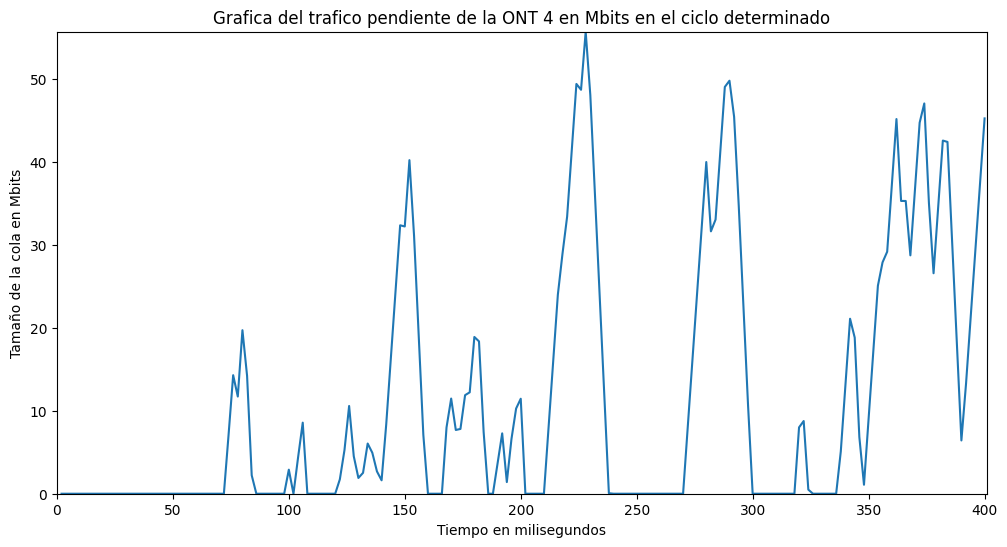

Valores de la ONT 4 de entrada son: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 140.48562031166523, 145.6278582112973, 694.7964541728394, 965.6449563925881, 36.64632433183579, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 228.480781936758, 1000.0, 152.89904086428763, 0.0, 0.0, 0.0, 323.76356687573127, 700.9561894074446, 977.3390070817841, 74.9148865429774, 163.44450333562133, 0.0, 112.45265225103174, 817.4991662193469, 1000.0, 889.5741948701769, 38.56175798393879, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 474.56435391833196, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 205.3569705053465, 986.4772770570589, 1000.0, 359.88004236565763, 1000.0, 281.29868670815017, 329.10876656707325, 298.1106940004868, 745.0374

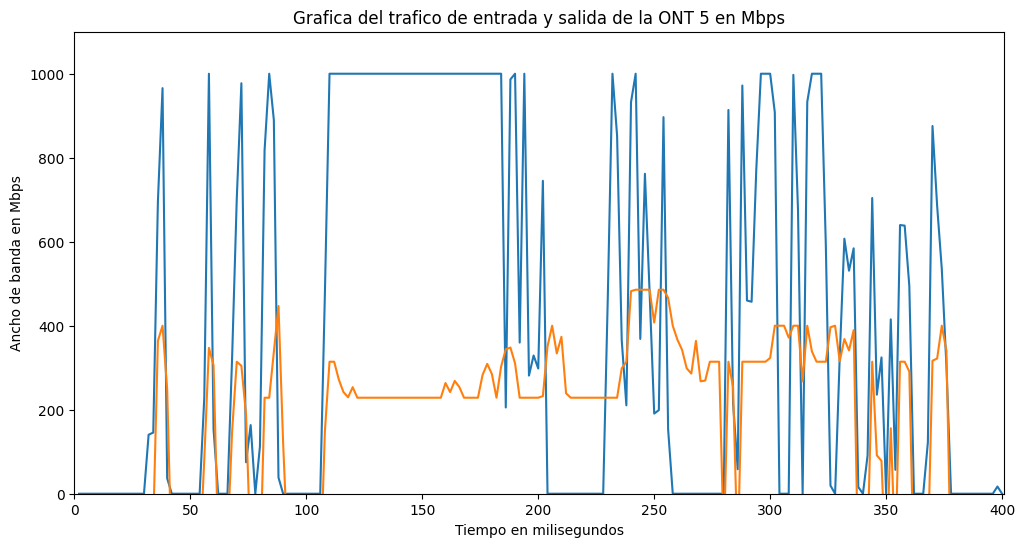

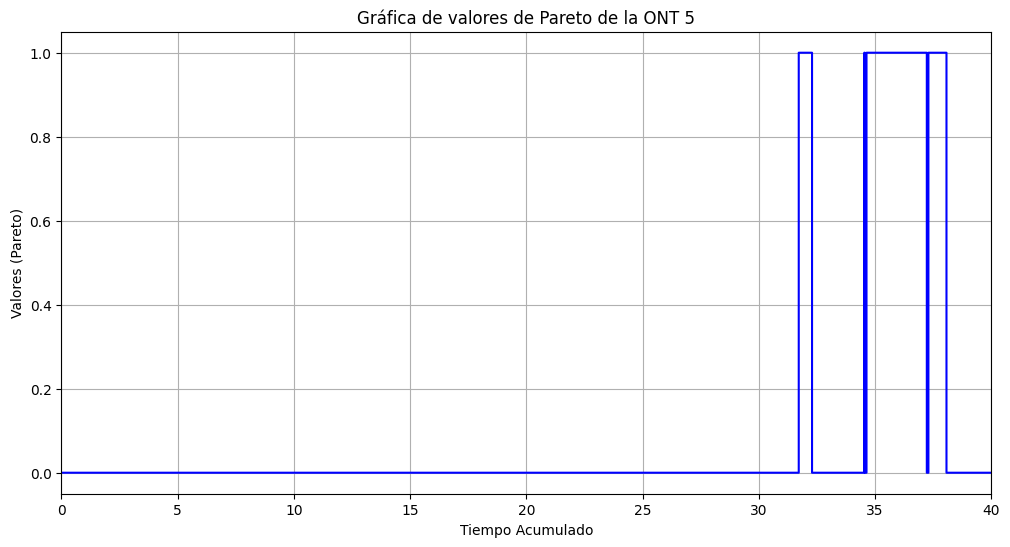

315.0342856703172


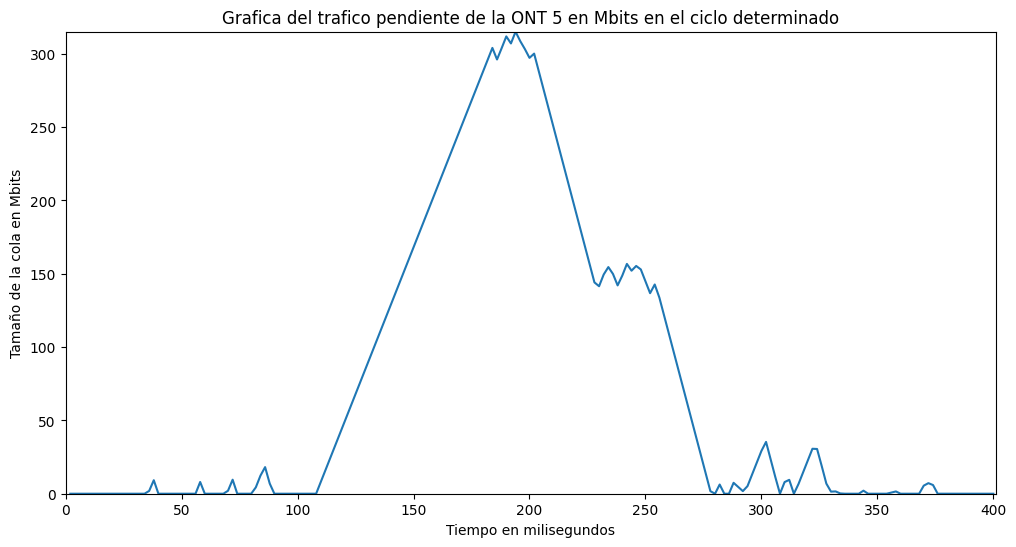

Valores de la ONT 5 de entrada son: [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 100

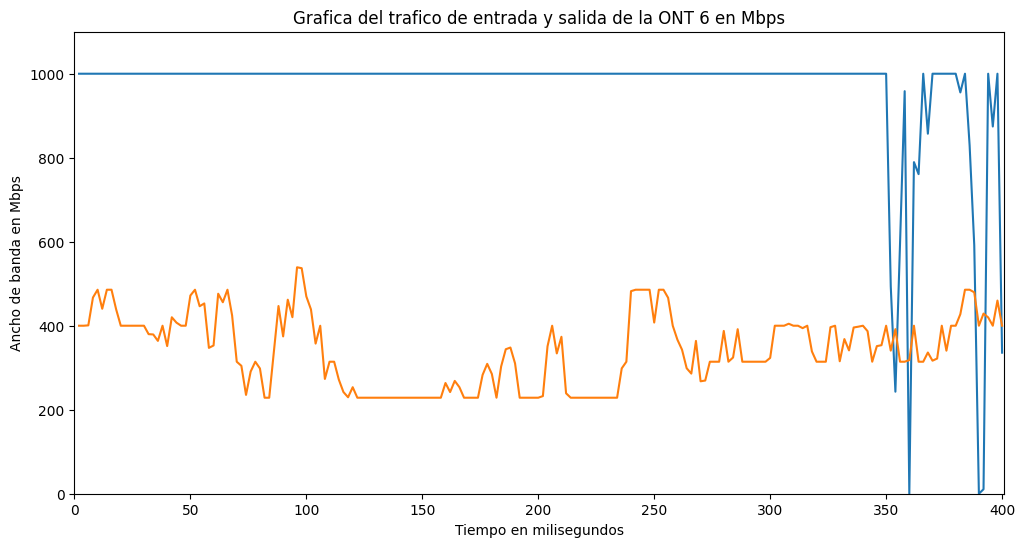

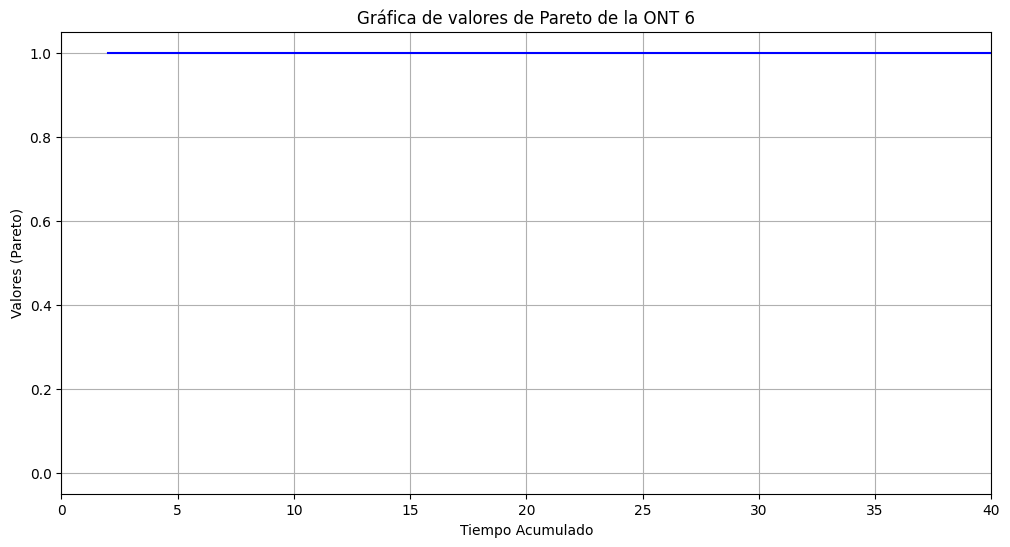

3515.995901631373


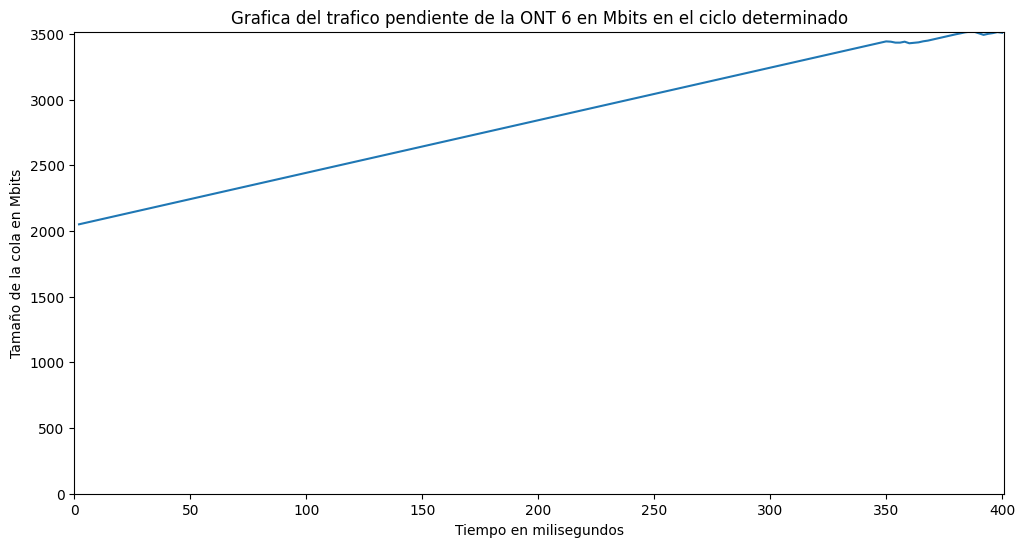

Valores de la ONT 6 de entrada son: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

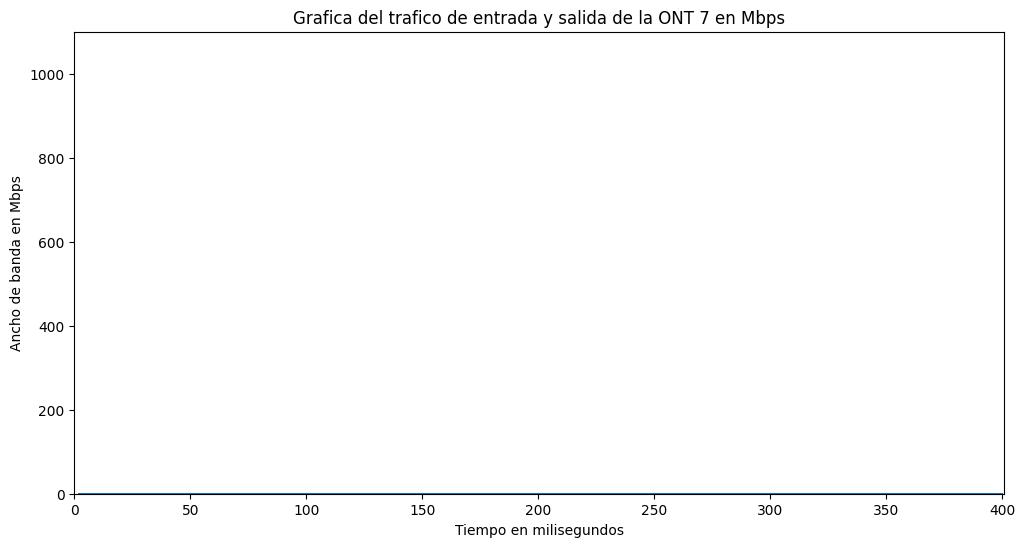

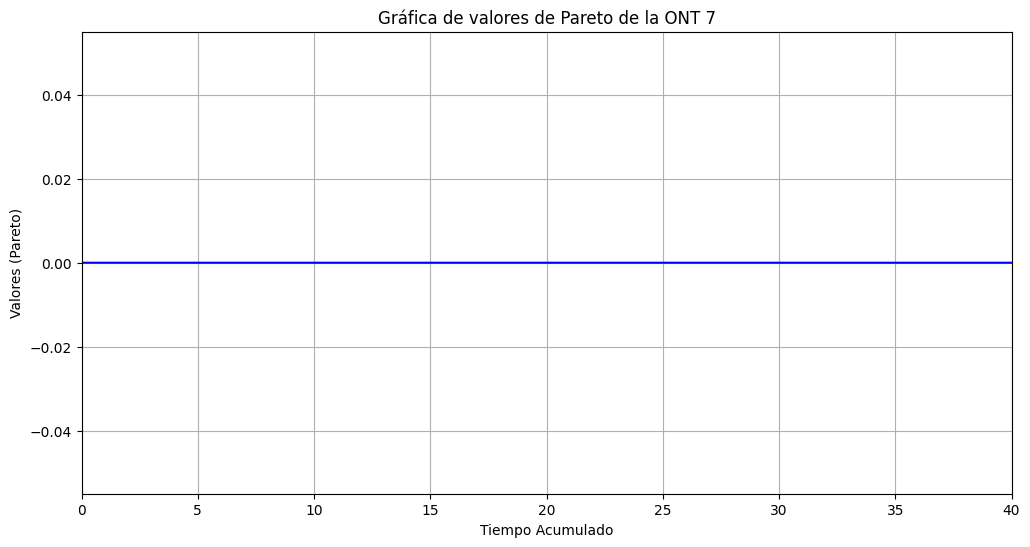

-2.74221109127393e-05


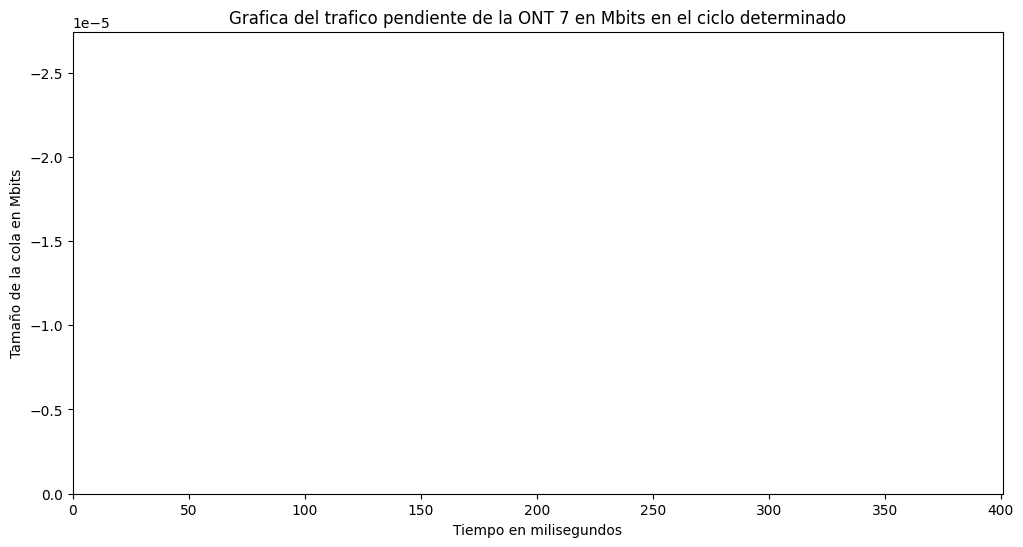

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.utils import set_random_seed
from custom_env.redes_opticas_env import RedesOpticasEnv

def make_env(num_ont, Vt=10e6,Vt_contratada=10e6/10, rank=0, seed=0):
    """
    Utility function for multiprocessed env.
    
    :param num_ont: Número de ONTs en la red
    :param Vt: Capacidad de tráfico
    :return: un entorno con configuración específica
    """
    def _init():
        env = RedesOpticasEnv(render_mode=None, num_ont=num_ont, Vt=Vt, Vt_contratada=Vt_contratada)
        return env
    return _init

def transpuesta(list_ont):
     #Hay que hacer la matriz transpuesta de la lista

    np_array = np.array(list_ont)

    # Transponer el array
    transposed_np_array = np_array.T

    # Convertir el array transpuesto de NumPy de nuevo a una lista de listas de Python
    list_transpuesta = transposed_np_array.tolist()

    return list_transpuesta


def grafico_pareto(valores_instantes, ont):

    valoresInstantesFinales=[]
    valoresPareto=[]

    # Modificar los valores de Pareto en posiciones pares donde el instante es 0
    for i in valores_instantes:
        cont=0
        for j in i:
            if cont%2==0:
                if j==0:
                    valoresInstantesFinales.append(j)
                    valoresPareto.append(0)
                else:
                    valoresInstantesFinales.append(j)
                    valoresPareto.append(1)
            else:
                if j==0:
                    valoresInstantesFinales.append(j)
                    valoresPareto.append(0)
                else:
                    valoresInstantesFinales.append(j)
                    valoresPareto.append(0)

            cont+=1


    # Crear una lista extendida para los instantes y valores Pareto
    extended_instantes = []  # Comenzar desde tiempo 0
    extended_pareto = []
    
    current_time = 0  # Tiempo acumulado actual
    
    # Añadir valores extendidos para mantener el gráfico en el eje y hasta el siguiente instante
    for i, valor in enumerate(valoresInstantesFinales):
        current_time += valor
        # Añadir el tiempo actual y su valor correspondiente de Pareto
        extended_instantes.append(current_time)
        if i < len(valoresPareto) - 1:
            extended_pareto.append(valoresPareto[i])
            extended_instantes.append(current_time)
            extended_pareto.append(valoresPareto[i+1])
        else:
            extended_pareto.append(valoresPareto[i])
    
    # Graficar
    plt.figure(figsize=(12, 6))
    plt.step(extended_instantes, extended_pareto, where='post', linestyle='-', color='blue')
    plt.xlabel('Tiempo Acumulado')
    plt.ylabel('Valores (Pareto)')
    plt.title(f'Gráfica de valores de Pareto de la ONT {ont+1}')
    plt.xlim([0,n_ciclos/5])
    plt.grid(True)
    plt.show()

#Funcion auxiliar para el array de los instantes de los ciclos y luego calcular la grafica de barras
def funcion_aux(array_valores):

    x=[[] for i in range(num_ont)]
    #y=[[] for i in range(num_ont)]

    for i, subarray in enumerate(array_valores):
        #print(f"Posición {i}:")
        # Iterar sobre cada subarray en la posición actual
        for j, sublist in enumerate(subarray):
            #print(f"    Subarray {j}:")
            # Iterar sobre cada valor en el subarray actual
            for k, valor in enumerate(sublist):
                #print(f"        Valor {k}: {valor}")
                x[j].append(valor)

    #print(f"Los valores de los instantes en la ont 1 son de x: {x[0]}")

    return x


if __name__ == "__main__":
    env_id = 'RedesOpticasEnv-v0'  # Hay que asegurarse de que este ID coincida con el registrado
    num_test = 20  #Ponemos el numero de test que necesitamos para que el algoritmo de aprendizaje aprenda.
    seed = np.random.randint(0, 10)  #Ponemos seeds aleatorias
    num_envs = 1  # Número de entornos paralelos
    #EL NUMERO DE ONTS PUEDE SER DEFINIDO DESDE ESTA VARIABLE(POSIBLE INPUT)
    #num_ont=int(input("Introduce el numero de unidades opticas(ont): "))
    num_ont=7
    #Establecemos el Vt
    #Vt=float(input("Introduce la velocidad de transmision maxima: "))
    Vt=10e9
    #Transmision de cada ciclo
    T=0.002
    #OLT Capacity
    OLT_Capacity=Vt*T
    #Velocidad de transmision contratada, lo ponemos a Vt/5 del Vt de la OLT inicialmente, lo que deberia de ser de maximo 2*10e8 lo que serian 200Mbps
    Vt_contratada=6000000000
    #Maximo de bits que se pueden transmitir en un ciclo en cada ont por la limitacion de la velocidad contratada
    Max_bits_ONT=Vt_contratada*T
    #Numero de ciclos que se van a ejecutar
    n_ciclos=int(input("Cuantos ciclos quiere ver: "))

    # Vector con los entornos establecidos
    vec_env = DummyVecEnv([make_env(num_ont, Vt,Vt_contratada, rank=i, seed=42) for i in range(num_envs)])
    
    
    n_steps = 16384  # Steps por actualización
    batch_size = 256  # Tamaño del mini-batch (16384 es múltiplo de 256)

    # Definir el modelo PPO con los parámetros ajustados
    model = PPO(
        "MlpPolicy",
        vec_env,
        verbose=1,
        n_steps=n_steps,  # Steps por actualización
        batch_size=batch_size,  # Tamaño del mini-batch
        learning_rate=0.00025,
        gamma=0.99,
        gae_lambda=0.95
    )
    model.learn(total_timesteps=50000)

    # Fase de pruebas

    #Establecemos un unico episodio a investigar
    num_test_episodes = 1  # Número de episodios de prueba

    # Lista para guardar la información de cada episodio
    episode_info = []  

    # Lista de en cada ont guardar el valor de su capacidad, de entrada salida y del pendiente(entrada-salida)
    list_ont = []
    list_ont_2 = []
    list_pendiente=[]

    # Guardar los estados de ON y OFF del estado de pareto
    estados_on_off_recolectados = []

    #Capacidad de la OLT
    tamano_cola=[]

    
    obs = vec_env.reset()  # Resetea el entorno al estado inicial
    _states = None  # Inicializa el estado del modelo
    for episode in range(num_test_episodes):
        
        done = np.array([False]*num_envs)  # Inicializa 'done' para todos los entornos
        step_counter = 0  # Contador de steps para limitar a 100

        while step_counter < n_ciclos:
            

            action, _states = model.predict(obs, state=_states, deterministic=True)  # Usamos el modelo para predecir la acción
            obs, rewards, dones, info = vec_env.step(action)

            # Guardamos la información del episodio.
            episode_info.append(info)
            for i in range(len(info)):  # Itera sobre cada sub-entorno
                
                suma = 0

                list_ont.append(info[i]['trafico_entrada'])
                list_ont_2.append(info[i]['trafico_salida'])
                list_pendiente.append(info[i]['trafico_pendiente'])
                estados_on_off_recolectados.append(info[i]['trafico_IN_ON_actual'])
            
            done |= dones  # Actualiza 'done' para todos los entornos
            step_counter += 1  # Incrementa el contador de steps


    #Hallamos el valor de la lista transpuesta, para los valores de entrada y de salida
    list_transpuesta=transpuesta(list_ont)

    # Convertir list_transpuesta a un array NumPy y dividir por 0.002
    #0.002*10e6(transformacion de bps a Mbps)=20000
    array_transpuesta = np.array(list_transpuesta) / 20000

    # Convertir array_transpuesta de vuelta a una lista de listas si es necesario
    list_valores_entrada = array_transpuesta.tolist()

    list_transpuesta_2=transpuesta(list_ont_2)

    
    # Convertir list_transpuesta a un array NumPy y dividir por 0.002
    #0.002*10e6(transformacion de bps a Mbps)=20000
    array_transpuesta_2 = np.array(list_transpuesta_2) / 20000

    # Convertir array_transpuesta de vuelta a una lista de listas si es necesario
    list_valores_salida = array_transpuesta_2.tolist()

    list_pendiente_transpuesta=transpuesta(list_pendiente)

    # Convertir list_transpuesta a un array NumPy y dividir por 0.002
    #0.002*1e6(transformacion de bps a Mbps)=20000
    array_pendiente_transpuesta = np.array(list_pendiente_transpuesta) / 1000000

    # Convertir array_transpuesta de vuelta a una lista de listas si es necesario
    list_pendiente_fin = array_pendiente_transpuesta.tolist()

    maximo_pendiente=[]

    #Hallamos el valor maximo de cada ciclo en cada ont para las graficas
    for i in range(num_ont):
        maximo_pendiente.append(max(list_pendiente_fin[i]))

    #Hallar valores de los instantes para el grafico de barras
    valoresInstantes=funcion_aux(estados_on_off_recolectados)

    #Graficas

    for i in range(num_ont):
        
        print(f"Valores de la ONT {i} de entrada son: {list_valores_entrada[i]}")
        print(f"Valores de la ONT {i} de salida son: {list_valores_salida[i]}")
        
        print(f"Los valores de los instantes de la ont {i+1} son de {valoresInstantes[i]}")

        nuevo_x = np.arange(2, 2 * n_ciclos + 1, 2)  # x se duplica para cada punto

        # Configurando las marcas del eje x para que aparezcan de dos en dos ciclos
        #plt.xticks(nuevo_x)

        #Grafica del trafico de pareto de las redes
        plt.figure(figsize=(12, 6))
        plt.ylim(0,1100)
        plt.xlim(0, 2 * n_ciclos + 1)  # Ajustamos xlim para acomodar el nuevo rango de x
        plt.xlabel('Tiempo en milisegundos')
        plt.ylabel('Ancho de banda en Mbps')
        plt.plot(nuevo_x, list_valores_entrada[i], label=f'Grafica de la ONT {i+1}')
        plt.plot(nuevo_x, list_valores_salida[i], label=f'Grafica del trafico de entrada y salida de la ONT {i+1}')
        plt.title(f'Grafica del trafico de entrada y salida de la ONT {i+1} en Mbps')
        plt.show()

        #Hacemos una funcion para la realizacion correcta de los valores para la grafica de pareto de ON y OFF de cada ONT
        grafico_pareto(valoresInstantes[i], i)

        #Grafica del trafico pendiente de la ont determinada
        plt.figure(figsize=(12, 6))
        print(maximo_pendiente[i])
        plt.ylim(0,maximo_pendiente[i])
        plt.xlim(0, 2 * n_ciclos + 1)  # Ajustamos xlim para acomodar el nuevo rango de x
        plt.xlabel('Tiempo en milisegundos')
        plt.ylabel('Tamaño de la cola en Mbits')
        plt.plot(nuevo_x,list_pendiente_fin[i], label=f'Grafica del trafico pendiente de la ONT {i+1}')
        plt.title(f'Grafica del trafico pendiente de la ONT {i+1} en Mbits en el ciclo determinado')
        plt.show()
        

